# 
#![Spark Logo](http://spark-mooc.github.io/web-assets/images/ta_Spark-logo-small.png) + ![Python Logo](http://spark-mooc.github.io/web-assets/images/python-logo-master-v3-TM-flattened_small.png)
# **基于Apache Spark的日志处理**


# 
### **Part 1: Apache Web Server日志文件格式**
####我们用到的日志文件在 [Apache Common Log Format (CLF)](http://httpd.apache.org/docs/1.3/logs.html#common)中。CLF定义的每条日志数据的格式如下所示：
`127.0.0.1 - - [01/Aug/1995:00:00:01 -0400] "GET /images/launch-logo.gif HTTP/1.0" 200 1839`
 
####现在给出每一部分的具体描述：


####* `127.0.0.1`

####这是用户请求服务器的IP地址。
#### 
 
 
####* `-`
####连词符号代表该变量不存在。
#### 
 
####* `-`
####连词符号代表该变量不存在。
#### 
 
####* `[01/Aug/1995:00:00:01 -0400]`
####服务器处理完请求的时间，具体格式为：
`[day/month/year:hour:minute:second timezone]`
  * ####day = 2 digits
  * ####month = 3 letters
  * ####year = 4 digits
  * ####hour = 2 digits
  * ####minute = 2 digits
  * ####second = 2 digits
  * ####zone = (\+ | \-) 4 digits
#### 
 
####* `"GET /images/launch-logo.gif HTTP/1.0"`
####这部分包含三个组成部分: 请求的类型 （比如 `GET`, `POST`等），对应请求的服务器URL、用户的协议版本。
#### 
 
####* `200`
####返回给用户的状态码。如200，300，404等。
#### 
 
####* `1839`
####返回给用户的数据的长度，如果没有返回数据，该值变为“_”。
#### 
 
### NASA-HTTP服务器日志
####我们用到了NASA Kennedy Space Center服务器的日志数据集。日志数据获取的链接为(http://ita.ee.lbl.gov/html/contrib/NASA-HTTP.html 。其中包含了两个月的所有HTTP请求，我们从中选取了一部分进行使用。

# 
### **(1a) 解析每一行日志**
####利用以上定义的CLF，我们将每一行日志转化后与我们定义的含有九个变量的数据模板进行比较，利用了python常规的[`search` function](https://docs.python.org/2/library/re.html#regular-expression-objects)。此方法将每一条日志的时间转化为了python的datetime。

In [1]:
import re
import datetime

from pyspark.sql import Row

month_map = {'Jan': 1, 'Feb': 2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7,
    'Aug':8,  'Sep': 9, 'Oct':10, 'Nov': 11, 'Dec': 12}

def parse_apache_time(s):
    """ Convert Apache time format into a Python datetime object
    Args:
        s (str): date and time in Apache time format
    Returns:
        datetime: datetime object (ignore timezone for now)
    """
    return datetime.datetime(int(s[7:11]),
                             month_map[s[3:6]],
                             int(s[0:2]),
                             int(s[12:14]),
                             int(s[15:17]),
                             int(s[18:20]))


def parseApacheLogLine(logline):
    """ Parse a line in the Apache Common Log format
    Args:
        logline (str): a line of text in the Apache Common Log format
    Returns:
        tuple: either a dictionary containing the parts of the Apache Access Log and 1,
               or the original invalid log line and 0
    """
    match = re.search(APACHE_ACCESS_LOG_PATTERN, logline)
    if match is None:
        return (logline, 0)
    size_field = match.group(9)
    if size_field == '-':
        size = long(0)
    else:
        size = long(match.group(9))
    return (Row(
        host          = match.group(1),
        client_identd = match.group(2),
        user_id       = match.group(3),
        date_time     = parse_apache_time(match.group(4)),
        method        = match.group(5),
        endpoint      = match.group(6),
        protocol      = match.group(7),
        response_code = int(match.group(8)),
        content_size  = size
    ), 1)

In [2]:
# A regular expression pattern to extract fields from the log line
APACHE_ACCESS_LOG_PATTERN = '^(\S+) (\S+) (\S+) \[([\w:/]+\s[+\-]\d{4})\] "(\S+) (\S+)\s*(\S*)\s*" (\d{3}) (\S+)'

### **(1b) 配置调试和初始化RDD创建**
####我们现在就可以将日志文件转化为RDD元素。

####我们用[`sc.textfile(logFile)`](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.SparkContext.textFile)导入文本文件，并把每一行日志转化为一个RDD元素。随后，我们用[`map(parseApacheLogLine)`](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.map)来实现RDD中每个元素的解析，并且把每一行作为一个 [`Row` object] 对返回。
####最后，我们解析后的RDD存入缓存以便调用。

#### 需要解析的数据量非常大，下面给出了一条日志数据的模板。我们需要通过自定义的模板来读出合法数据（valid lines）和非法数据（invalid lines），其中符合模板类型的日志数据为合法数据（invalid line）。

`127.0.0.1 - - [01/Aug/1995:00:00:01 -0400] "GET /images/launch-logo.gif HTTP/1.0" 200 1839`

In [3]:
import sys
import os
from test_helper import Test

baseDir = os.path.join('data')
inputPath = os.path.join('cs100', 'lab2', 'apache.access.log.PROJECT')
logFile = os.path.join(baseDir, inputPath)

def parseLogs():
    """ Read and parse log file """
    parsed_logs = (sc
                   .textFile(logFile)
                   .map(parseApacheLogLine)
                   .cache())

    access_logs = (parsed_logs
                   .filter(lambda s: s[1] == 1)
                   .map(lambda s: s[0])
                   .cache())

    failed_logs = (parsed_logs
                   .filter(lambda s: s[1] == 0)
                   .map(lambda s: s[0]))
    failed_logs_count = failed_logs.count()
    if failed_logs_count > 0:
        print 'Number of invalid logline: %d' % failed_logs.count()
        for line in failed_logs.take(20):
            print 'Invalid logline: %s' % line

    print 'Read %d lines, successfully parsed %d lines, failed to parse %d lines' % (parsed_logs.count(), access_logs.count(), failed_logs.count())
    return parsed_logs, access_logs, failed_logs


parsed_logs, access_logs, failed_logs = parseLogs()

#利用这样的正则表达式
#APACHE_ACCESS_LOG_PATTERN = '^(\S+) (\S+) (\S+) \[([\w:/]+\s[+\-]\d{4})\] "(\S+) (\S+)\s*(\S*)" (\d{3}) (\S+)'
#会错误地排除一些数据，比如
#127.0.0.1 - - [01/Aug/1995:00:00:01 -0400] "GET /images/launch-logo.gif HTTP/1.0 " 200 1839

Read 1043177 lines, successfully parsed 1043177 lines, failed to parse 0 lines


In [5]:
# TEST Data cleaning (1c)
Test.assertEquals(failed_logs.count(), 0, 'incorrect failed_logs.count()')
Test.assertEquals(parsed_logs.count(), 1043177 , 'incorrect parsed_logs.count()')
Test.assertEquals(access_logs.count(), parsed_logs.count(), 'incorrect access_logs.count()')

1 test passed.
1 test passed.
1 test passed.


# 
### **Part 2: 网络服务器日志样例处理**
 
####现在我们有了许多带有日志信息的RDD作为Row对象，对于这些RDD，我们可以进行一系列操作。
 
#### **(2a) 求服务器返回数据长度的平均、最大、最小值**
 
####我们现在对服务器返回的数据长度进行操作，分别计算服务器返回数据的平均值、最大值和最小值。
 
####我们通过在`access_logs` RDD上运用 `map` 函数进行transform操作，运用 `Reduce` 函数进行action操作，依次来实现对半结构化日志数据的操作。

In [6]:
# Calculate statistics based on the content size.
content_sizes = access_logs.map(lambda log: log.content_size).cache()
print 'Content Size Avg: %i, Min: %i, Max: %s' % (
    content_sizes.reduce(lambda a, b : a + b) / content_sizes.count(),
    content_sizes.min(),
    content_sizes.max())

Content Size Avg: 17531, Min: 0, Max: 3421948


#### **(2b) 状态码的统计 **
####对百万级日志数据所包含的服务器返回给用户的的状态码进行统计，计算不同状态码返回的次数。最后。通过 [`take`](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.take) 函数对处理RDD后的结果进行cache.

In [7]:
# Response Code to Count
responseCodeToCount = (access_logs
                       .map(lambda log: (log.response_code, 1))
                       .reduceByKey(lambda a, b : a + b)
                       .cache())
responseCodeToCountList = responseCodeToCount.take(100)
print 'Found %d response codes' % len(responseCodeToCountList)
print 'Response Code Counts: %s' % responseCodeToCountList


Found 7 response codes
Response Code Counts: [(200, 940847), (304, 79824), (404, 6185), (500, 2), (501, 17), (302, 16244), (403, 58)]


#### **(2c) 利用`matplotlib`对状态码进行绘图**
####计算每个状态码出现的频率并绘图。

In [8]:
labels = responseCodeToCount.map(lambda (x, y): x).collect()
print labels
count = access_logs.count()
fracs = responseCodeToCount.map(lambda (x, y): (float(y) / count)).collect()
print fracs

[200, 304, 404, 500, 501, 302, 403]
[0.9019054292799784, 0.07652009198822443, 0.005929003419362198, 1.9172201841106543e-06, 1.629637156494056e-05, 0.015571662335346735, 5.5599385339208974e-05]


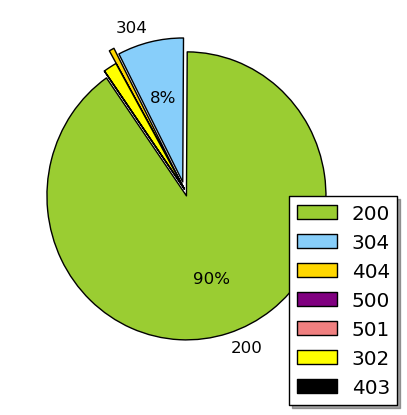

In [9]:
import matplotlib.pyplot as plt


def pie_pct_format(value):
    """ Determine the appropriate format string for the pie chart percentage label
    Args:
        value: value of the pie slice
    Returns:
        str: formated string label; if the slice is too small to fit, returns an empty string for label
    """
    return '' if value < 7 else '%.0f%%' % value

fig = plt.figure(figsize=(4.5, 4.5), facecolor='white', edgecolor='white')
colors = ['yellowgreen', 'lightskyblue', 'gold', 'purple', 'lightcoral', 'yellow', 'black']
explode = (0.05, 0.05, 0.1, 0, 0, 0, 0)
patches, texts, autotexts = plt.pie(fracs, labels=labels, colors=colors,
                                    explode=explode, autopct=pie_pct_format,
                                    shadow=False,  startangle=125)
for text, autotext in zip(texts, autotexts):
    if autotext.get_text() == '':
        text.set_text('')  # If the slice is small to fit, don't show a text label
plt.legend(labels, loc=(0.80, -0.1), shadow=True)
pass

#### **(2d) 找出访问次数超过10的客户端ip**

In [ ]:
# Any hosts that has accessed the server more than 10 times.
hostCountPairTuple = access_logs.map(lambda log: (log.host, 1))

hostSum = hostCountPairTuple.reduceByKey(lambda a, b : a + b)

hostMoreThan10 = hostSum.filter(lambda s: s[1] > 10)

hostsPick20 = (hostMoreThan10
               .map(lambda s: s[0])
               .take(20))

print 'Any 20 hosts that have accessed more then 10 times: %s' % hostsPick20

#### **(2e)最常被访问的10个资源路径URI **

In [ ]:
# Top Endpoints
endpointCounts = (access_logs
                  .map(lambda log: (log.endpoint, 1))
                  .reduceByKey(lambda a, b : a + b))

topEndpoints = endpointCounts.takeOrdered(10, lambda s: -1 * s[1])

print 'Top Ten Endpoints: %s' % topEndpoints

# 
### **Part 3: 网络服务器日志文件的分析**


#### **(3a) 请求返回错误次数最多的十个资源路径URI**

In [11]:
# TODO: Replace <FILL IN> with appropriate code
# HINT: Each of these <FILL IN> below could be completed with a single transformation or action.
# You are welcome to structure your solution in a different way, so long as
# you ensure the variables used in the next Test section are defined (ie. endpointSum, topTenErrURLs).

not200 = access_logs.filter(lambda log: log.response_code != 200)

endpointCountPairTuple = not200.map(lambda log: (log.endpoint, 1))

endpointSum = endpointCountPairTuple.reduceByKey(lambda a,b: a+b)

topTenErrURLs = endpointSum.takeOrdered(10, lambda s: -1*s[1])
print 'Top Ten failed URLs: %s' % topTenErrURLs

Top Ten failed URLs: [(u'/images/NASA-logosmall.gif', 8761), (u'/images/KSC-logosmall.gif', 7236), (u'/images/MOSAIC-logosmall.gif', 5197), (u'/images/USA-logosmall.gif', 5157), (u'/images/WORLD-logosmall.gif', 5020), (u'/images/ksclogo-medium.gif', 4728), (u'/history/apollo/images/apollo-logo1.gif', 2907), (u'/images/launch-logo.gif', 2811), (u'/', 2199), (u'/images/ksclogosmall.gif', 1622)]


In [12]:
# TEST Top ten error endpoints (3a)
Test.assertEquals(endpointSum.count(), 7689, 'incorrect count for endpointSum')
Test.assertEquals(topTenErrURLs, [(u'/images/NASA-logosmall.gif', 8761), (u'/images/KSC-logosmall.gif', 7236), (u'/images/MOSAIC-logosmall.gif', 5197), (u'/images/USA-logosmall.gif', 5157), (u'/images/WORLD-logosmall.gif', 5020), (u'/images/ksclogo-medium.gif', 4728), (u'/history/apollo/images/apollo-logo1.gif', 2907), (u'/images/launch-logo.gif', 2811), (u'/', 2199), (u'/images/ksclogosmall.gif', 1622)], 'incorrect Top Ten failed URLs (topTenErrURLs)')

1 test passed.
1 test passed.


#### **(3b) 统计客户端ip的个数**

In [13]:
# TODO: Replace <FILL IN> with appropriate code
# HINT: Do you recall the tips from (3a)? Each of these <FILL IN> could be an transformation or action.

hosts = access_logs.map(lambda log: (log.host, 1))

uniqueHosts = hosts.reduceByKey(lambda a,b: a+b)

uniqueHostCount = uniqueHosts.count()
print 'Unique hosts: %d' % uniqueHostCount

Unique hosts: 54507


In [14]:
# TEST Number of unique hosts (3b)
Test.assertEquals(uniqueHostCount, 54507, 'incorrect uniqueHostCount')

1 test passed.


#### **(3c) 统计每天访问的用户量**
####我们选取的数据包含了某个月中22天 NASA-HTTP 服务器的部分日志请求，现在我们计算每天访问该服务器的用户数量。

In [15]:
# TODO: Replace <FILL IN> with appropriate code

dayToHostPairTuple = access_logs.map(lambda log:(log.date_time.day, log.host)).distinct()

dayGroupedHosts = dayToHostPairTuple.map(lambda s: (s[0], 1))

dailyHosts = dayGroupedHosts.reduceByKey(lambda a,b: a+b).cache()

dailyHostsList = dailyHosts.takeOrdered(30, lambda s: s[0])
print 'Unique hosts per day: %s' % dailyHostsList

Unique hosts per day: [(1, 2582), (3, 3222), (4, 4190), (5, 2502), (6, 2537), (7, 4106), (8, 4406), (9, 4317), (10, 4523), (11, 4346), (12, 2864), (13, 2650), (14, 4454), (15, 4214), (16, 4340), (17, 4385), (18, 4168), (19, 2550), (20, 2560), (21, 4134), (22, 4456)]


In [16]:
# TEST Number of unique daily hosts (3c)
Test.assertEquals(dailyHosts.count(), 21, 'incorrect dailyHosts.count()')
Test.assertEquals(dailyHostsList, [(1, 2582), (3, 3222), (4, 4190), (5, 2502), (6, 2537), (7, 4106), (8, 4406), (9, 4317), (10, 4523), (11, 4346), (12, 2864), (13, 2650), (14, 4454), (15, 4214), (16, 4340), (17, 4385), (18, 4168), (19, 2550), (20, 2560), (21, 4134), (22, 4456)], 'incorrect dailyHostsList')
Test.assertTrue(dailyHosts.is_cached, 'incorrect dailyHosts.is_cached')

1 test passed.
1 test passed.
1 test passed.


#### **(3d) 对每天访问的用户量进行图形化展示**

In [20]:
# TODO: Replace <FILL IN> with appropriate code

daysWithHosts = dailyHosts.map(lambda s: s[0]).collect()
hosts = dailyHosts.map(lambda s: s[1]).collect()

In [ ]:
# TEST Visualizing unique daily hosts (3d)
test_days = range(1, 23)
test_days.remove(2)
Test.assertEquals(daysWithHosts, test_days, 'incorrect days')
Test.assertEquals(hosts, [2582, 3222, 4190, 2502, 2537, 4106, 4406, 4317, 4523, 4346, 2864, 2650, 4454, 4214, 4340, 4385, 4168, 2550, 2560, 4134, 4456], 'incorrect hosts')

In [ ]:
fig = plt.figure(figsize=(8,4.5), facecolor='white', edgecolor='white')
plt.axis([min(daysWithHosts), max(daysWithHosts), 0, max(hosts)+500])
plt.grid(b=True, which='major', axis='y')
plt.xlabel('Day')
plt.ylabel('Hosts')
plt.plot(daysWithHosts, hosts)
pass

# 
### **Part 4: 对 404 NOT FOUND 状态码的分析**
 
####对日志中包含的所有具有404状态码的日志条目(比如没有找到的文件或对象)进行深入分析。

#### **(4a) 统计404 NOT FOUND数量**
#### 对那些状态码为404的日志条目创建对应的RDD，并对RDD进行对应操作，最后进行`cache()`处理。通过日志文件统计状态码为404的服务器请求操作的数量。

In [10]:
# TODO: Replace <FILL IN> with appropriate code

badRecords = (access_logs
              .filter(lambda log: log.response_code == 404)).cache()
print 'Found %d 404 URLs' % badRecords.count()

Found 6185 404 URLs


In [11]:
# TEST Counting 404 (4a)
Test.assertEquals(badRecords.count(), 6185, 'incorrect badRecords.count()')
Test.assertTrue(badRecords.is_cached, 'incorrect badRecords.is_cached')

1 test passed.
1 test passed.


#### **(4b) 查找返回404状态码的服务器URI **
####运用RDD查找在用户请求后返回404状态码的URI，打印出40个不同的服务器URI，不得重复。

In [13]:
# TODO: Replace <FILL IN> with appropriate code

badEndpoints = badRecords.map(lambda log: log.endpoint)

badUniqueEndpoints = badEndpoints.distinct()

badUniqueEndpointsPick40 = badUniqueEndpoints.take(40)
print '404 URLS: %s' % badUniqueEndpointsPick40

404 URLS: [u'/11/history/apollo/images/', u'/128.159.104.89/tv/tv.html', u'/imag', u'/shuttle/missionssts-70/woodpecker.html', u'/~terrig/bookmark.html', u'/elv/ATLAS_CENTAUR/p-ae.gif', u'/pub.win', u'/ksc.nasa.gov/images/ksclogo-medium.gif', u'/history/apollo-13', u'/shuttle/missioins/sts-70/movies/', u'/shuttle/missions/sts-69/mission-sts-74.html', u'/shuttle/missions/sts-80/mission-sts-80.html', u'/histort/apollo/apollo13', u'/www/ksc', u'/shuttle/miccions/sts-73/mission-sts-73.html', u'/images/lf.gif', u'/shuttle/Missions/missions.html', u'/ksc', u'/shuttle/missions/mission.html/', u'/images/jpeg/', u'/shuttle/missions/sts-71/sts-69-info.html', u'/images/crawlerway-logo.gif', u'/home/whats-cool.html', u'/procurement/business/ciao1.htm', u'/icons/blank', u'/HISTORY/APOLLO/', u'/finance/main.html', u'/history/apollo/apollo-13/apollo_13.html', u'/shuttle/countdown/images/yforw.gif', u'/intersex.com/crawler.gif', u'/history/apollo-13-info.html', u'/images/hq.jpeg', u'/history/apollo/ap

In [14]:
# TEST Listing 404 records (4b)

badUniqueEndpointsSet40 = set(badUniqueEndpointsPick40)
Test.assertEquals(len(badUniqueEndpointsSet40), 40, 'badUniqueEndpointsPick40 not distinct')

1 test passed.


#### **(4c) 在4a的基础上查找出被请求次数最多的20个不存在的URI **

In [15]:
# TODO: Replace <FILL IN> with appropriate code

badEndpointsCountPairTuple = badRecords.map(lambda log: (log.endpoint, 1))

badEndpointsSum = badEndpointsCountPairTuple.reduceByKey(lambda a,b: a+b)

badEndpointsTop20 = badEndpointsSum.takeOrdered(20, lambda s: -1*s[1])
print 'Top Twenty 404 URLs: %s' % badEndpointsTop20

Top Twenty 404 URLs: [(u'/pub/winvn/readme.txt', 633), (u'/pub/winvn/release.txt', 494), (u'/shuttle/missions/STS-69/mission-STS-69.html', 431), (u'/images/nasa-logo.gif', 319), (u'/elv/DELTA/uncons.htm', 178), (u'/shuttle/missions/sts-68/ksc-upclose.gif', 156), (u'/history/apollo/sa-1/sa-1-patch-small.gif', 146), (u'/images/crawlerway-logo.gif', 120), (u'/://spacelink.msfc.nasa.gov', 117), (u'/history/apollo/pad-abort-test-1/pad-abort-test-1-patch-small.gif', 100), (u'/history/apollo/a-001/a-001-patch-small.gif', 97), (u'/images/Nasa-logo.gif', 85), (u'/shuttle/resources/orbiters/atlantis.gif', 64), (u'/history/apollo/images/little-joe.jpg', 62), (u'/images/lf-logo.gif', 59), (u'/shuttle/resources/orbiters/discovery.gif', 56), (u'/shuttle/resources/orbiters/challenger.gif', 54), (u'/robots.txt', 53), (u'/elv/new01.gif>', 43), (u'/history/apollo/pad-abort-test-2/pad-abort-test-2-patch-small.gif', 38)]


In [ ]:
# TEST Top twenty 404 URLs (4c)
Test.assertEquals(badEndpointsTop20, [(u'/pub/winvn/readme.txt', 633), (u'/pub/winvn/release.txt', 494), (u'/shuttle/missions/STS-69/mission-STS-69.html', 431), (u'/images/nasa-logo.gif', 319), (u'/elv/DELTA/uncons.htm', 178), (u'/shuttle/missions/sts-68/ksc-upclose.gif', 156), (u'/history/apollo/sa-1/sa-1-patch-small.gif', 146), (u'/images/crawlerway-logo.gif', 120), (u'/://spacelink.msfc.nasa.gov', 117), (u'/history/apollo/pad-abort-test-1/pad-abort-test-1-patch-small.gif', 100), (u'/history/apollo/a-001/a-001-patch-small.gif', 97), (u'/images/Nasa-logo.gif', 85), (u'/shuttle/resources/orbiters/atlantis.gif', 64), (u'/history/apollo/images/little-joe.jpg', 62), (u'/images/lf-logo.gif', 59), (u'/shuttle/resources/orbiters/discovery.gif', 56), (u'/shuttle/resources/orbiters/challenger.gif', 54), (u'/robots.txt', 53), (u'/elv/new01.gif>', 43), (u'/history/apollo/pad-abort-test-2/pad-abort-test-2-patch-small.gif', 38)], 'incorrect badEndpointsTop20')

#### **(4d) 查找出收到404状态码返回次数最多的25个用户**

In [16]:
# TODO: Replace <FILL IN> with appropriate code

errHostsCountPairTuple = badRecords.map(lambda log: (log.host, 1))

errHostsSum = errHostsCountPairTuple.reduceByKey(lambda a,b: a+b)

errHostsTop25 = errHostsSum.takeOrdered(25, lambda s: -1*s[1])
print 'Top 25 hosts that generated errors: %s' % errHostsTop25

Top 25 hosts that generated errors: [(u'piweba3y.prodigy.com', 39), (u'maz3.maz.net', 39), (u'gate.barr.com', 38), (u'm38-370-9.mit.edu', 37), (u'ts8-1.westwood.ts.ucla.edu', 37), (u'nexus.mlckew.edu.au', 37), (u'204.62.245.32', 33), (u'spica.sci.isas.ac.jp', 27), (u'163.206.104.34', 27), (u'www-d4.proxy.aol.com', 26), (u'203.13.168.24', 25), (u'www-c4.proxy.aol.com', 25), (u'203.13.168.17', 25), (u'internet-gw.watson.ibm.com', 24), (u'crl5.crl.com', 23), (u'scooter.pa-x.dec.com', 23), (u'piweba5y.prodigy.com', 23), (u'onramp2-9.onr.com', 22), (u'slip145-189.ut.nl.ibm.net', 22), (u'198.40.25.102.sap2.artic.edu', 21), (u'gn2.getnet.com', 20), (u'msp1-16.nas.mr.net', 20), (u'dial055.mbnet.mb.ca', 19), (u'isou24.vilspa.esa.es', 19), (u'tigger.nashscene.com', 19)]


In [17]:
# TEST Top twenty-five 404 response code hosts (4d)

Test.assertEquals(len(errHostsTop25), 25, 'length of errHostsTop25 is not 25')
Test.assertEquals(len(set(errHostsTop25) - set([(u'maz3.maz.net', 39), (u'piweba3y.prodigy.com', 39), (u'gate.barr.com', 38), (u'm38-370-9.mit.edu', 37), (u'ts8-1.westwood.ts.ucla.edu', 37), (u'nexus.mlckew.edu.au', 37), (u'204.62.245.32', 33), (u'163.206.104.34', 27), (u'spica.sci.isas.ac.jp', 27), (u'www-d4.proxy.aol.com', 26), (u'www-c4.proxy.aol.com', 25), (u'203.13.168.24', 25), (u'203.13.168.17', 25), (u'internet-gw.watson.ibm.com', 24), (u'scooter.pa-x.dec.com', 23), (u'crl5.crl.com', 23), (u'piweba5y.prodigy.com', 23), (u'onramp2-9.onr.com', 22), (u'slip145-189.ut.nl.ibm.net', 22), (u'198.40.25.102.sap2.artic.edu', 21), (u'gn2.getnet.com', 20), (u'msp1-16.nas.mr.net', 20), (u'isou24.vilspa.esa.es', 19), (u'dial055.mbnet.mb.ca', 19), (u'tigger.nashscene.com', 19)])), 0, 'incorrect errHostsTop25')

1 test passed.
1 test passed.


#### **(4e)  统计每天返回的404状态码数量 **

In [18]:
# TODO: Replace <FILL IN> with appropriate code

errDateCountPairTuple = badRecords.map(lambda log: (log.date_time.day, 1))

errDateSum = errDateCountPairTuple.reduceByKey(lambda a,b: a+b)

errDateSorted = (errDateSum
                 .sortByKey()).cache()

errByDate = errDateSorted.take(30)
print '404 Errors by day: %s' % errByDate

404 Errors by day: [(1, 243), (3, 303), (4, 346), (5, 234), (6, 372), (7, 532), (8, 381), (9, 279), (10, 314), (11, 263), (12, 195), (13, 216), (14, 287), (15, 326), (16, 258), (17, 269), (18, 255), (19, 207), (20, 312), (21, 305), (22, 288)]


In [19]:
# TEST 404 response codes per day (4e)
Test.assertEquals(errByDate, [(1, 243), (3, 303), (4, 346), (5, 234), (6, 372), (7, 532), (8, 381), (9, 279), (10, 314), (11, 263), (12, 195), (13, 216), (14, 287), (15, 326), (16, 258), (17, 269), (18, 255), (19, 207), (20, 312), (21, 305), (22, 288)], 'incorrect errByDate')
Test.assertTrue(errDateSorted.is_cached, 'incorrect errDateSorted.is_cached')

1 test passed.
1 test passed.


#### ** (4f)对每天返回的404状态码数量进行可视化操作 **

In [21]:
# TODO: Replace <FILL IN> with appropriate code

daysWithErrors404 = errDateSorted.map(lambda s: s[0]).collect()
errors404ByDay = errDateSorted.map(lambda s: s[1]).collect()

In [22]:
# TEST Visualizing the 404 Response Codes by Day (4f)
Test.assertEquals(daysWithErrors404, [1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22], 'incorrect daysWithErrors404')
Test.assertEquals(errors404ByDay, [243, 303, 346, 234, 372, 532, 381, 279, 314, 263, 195, 216, 287, 326, 258, 269, 255, 207, 312, 305, 288], 'incorrect errors404ByDay')

1 test passed.
1 test passed.


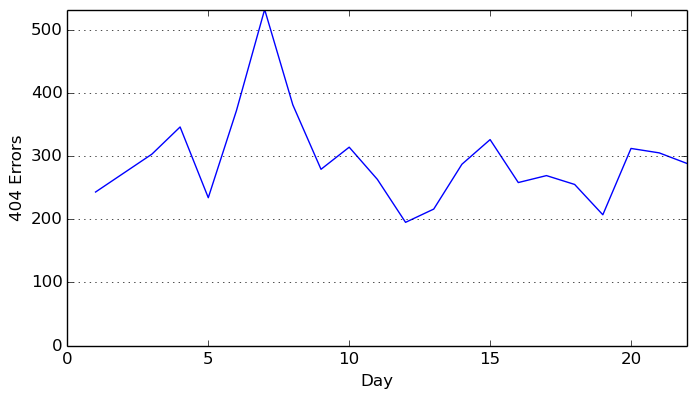

In [23]:
fig = plt.figure(figsize=(8,4.2), facecolor='white', edgecolor='white')
plt.axis([0, max(daysWithErrors404), 0, max(errors404ByDay)])
plt.grid(b=True, which='major', axis='y')
plt.xlabel('Day')
plt.ylabel('404 Errors')
plt.plot(daysWithErrors404, errors404ByDay)
pass

#### **(4g) 查找返回404状态码次数最多的5天 **

In [ ]:
# TODO: Replace <FILL IN> with appropriate code

topErrDate = errDateSorted.takeOrdered(5, lambda s: -1*s[1])
print 'Top Five dates for 404 requests: %s' % topErrDate

In [ ]:
# TEST Five dates for 404 requests (4g)
Test.assertEquals(topErrDate, [(7, 532), (8, 381), (6, 372), (4, 346), (15, 326)], 'incorrect topErrDate')

#### **(4h) 统计每小时返回的404状态码次数**
####我们用到的日志数据涵盖了22天的日志条目，我们需要综合考虑22天中各个小时404状态码返回的数量。

In [24]:
# TODO: Replace <FILL IN> with appropriate code

hourCountPairTuple = badRecords.map(lambda log: (log.date_time.hour, 1))

hourRecordsSum = hourCountPairTuple.reduceByKey(lambda a,b: a+b)

hourRecordsSorted = (hourRecordsSum
                     .sortByKey()).cache()

errHourList = hourRecordsSorted.take(24)
print 'Top hours for 404 requests: %s' % errHourList

Top hours for 404 requests: [(0, 175), (1, 171), (2, 422), (3, 272), (4, 102), (5, 95), (6, 93), (7, 122), (8, 199), (9, 185), (10, 329), (11, 263), (12, 438), (13, 397), (14, 318), (15, 347), (16, 373), (17, 330), (18, 268), (19, 269), (20, 270), (21, 241), (22, 234), (23, 272)]


In [25]:
# TEST Hourly 404 response codes (4h)
Test.assertEquals(errHourList, [(0, 175), (1, 171), (2, 422), (3, 272), (4, 102), (5, 95), (6, 93), (7, 122), (8, 199), (9, 185), (10, 329), (11, 263), (12, 438), (13, 397), (14, 318), (15, 347), (16, 373), (17, 330), (18, 268), (19, 269), (20, 270), (21, 241), (22, 234), (23, 272)], 'incorrect errHourList')
Test.assertTrue(hourRecordsSorted.is_cached, 'incorrect hourRecordsSorted.is_cached')

1 test passed.
1 test passed.


#### **(4i) 对每小时返回的404状态码次数进行可视化操作**

In [26]:
# TODO: Replace <FILL IN> with appropriate code

hoursWithErrors404 = hourRecordsSorted.map(lambda s: s[0]).collect()
errors404ByHours = hourRecordsSorted.map(lambda s: s[1]).collect()

In [27]:
# TEST Visualizing the 404 Response Codes by Hour (4i)
Test.assertEquals(hoursWithErrors404, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23], 'incorrect hoursWithErrors404')
Test.assertEquals(errors404ByHours, [175, 171, 422, 272, 102, 95, 93, 122, 199, 185, 329, 263, 438, 397, 318, 347, 373, 330, 268, 269, 270, 241, 234, 272], 'incorrect errors404ByHours')

1 test passed.
1 test passed.


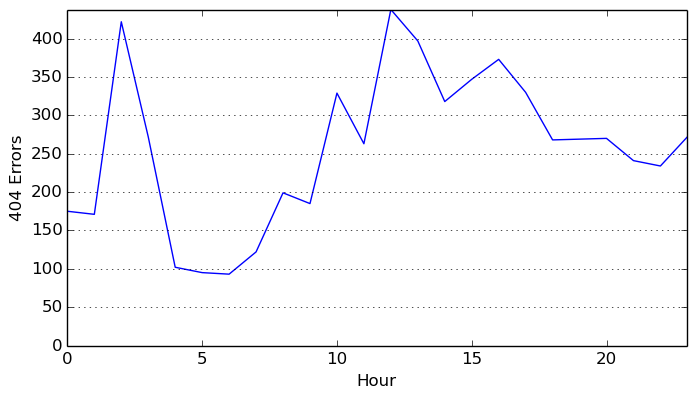

In [28]:
fig = plt.figure(figsize=(8,4.2), facecolor='white', edgecolor='white')
plt.axis([0, max(hoursWithErrors404), 0, max(errors404ByHours)])
plt.grid(b=True, which='major', axis='y')
plt.xlabel('Hour')
plt.ylabel('404 Errors')
plt.plot(hoursWithErrors404, errors404ByHours)
pass